### Importar Bibliotecas

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch

palette = "Set2"
sns.set(style="whitegrid", font_scale=0.8, palette=palette)

from models import SqueezeNetCAM
from utils import load_checkpoint, valid_transformations, train_transformations, train_valid_split_multilabel
from dataset import HPADatasetFourChannelsImages as HPADataset
from dataset import classes_map

### Carregar Modelo

In [19]:
# Instanciar o modelo
model = SqueezeNetCAM(num_classes=19)

# SqueezeNet
# Congelar todas as camadas por padrão
for param in model.parameters():
    param.requires_grad = False

# Descongelar a primeira camada (features[0]) e a última camada (classifier)
for param in model.squeezenet.features[0].parameters():
    param.requires_grad = True

# Descongelar a última camada
for param in model.squeezenet.classifier.parameters():
    param.requires_grad = True

# Definir o otimizador 
learning_rate = 0.0005
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

# Carregar checkpoint
filename = '/mnt/ssd/hpa-single-cell-image-classification/checkpoint_15.pth'
epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, filename=filename)

/home/juliana/Documentos/hpa-single-cell-classification/utils.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


### Carregar Dados

In [20]:
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/join_resized_train'
labels_csv = '/mnt/ssd/hpa-single-cell-image-classification/train.csv'

# Carregar os dados
train, valid = train_valid_split_multilabel(
    hpa_dataset_class=HPADataset,
    dataset_dir=dataset_dir,
    labels_csv=labels_csv,
    train_transform=train_transformations(),
    valid_transform=valid_transformations(),
    test_size=0.20,
    random_state=78
)

# Loaders
batch_size = 16

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)


### Segmentar 

In [21]:
input_image, target = next(iter(train_loader))

# Supondo que você já tem a saída do modelo e os mapas de ativação
output, feature_map, pooled_output = model(input_image)


In [22]:
def visualize_cams(cams, class_names=None):
    """
    Visualiza os mapas de ativação (CAMs) para cada classe de uma imagem.

    Parâmetros:
        cams (torch.Tensor): Mapas de ativação com forma [num_classes, H, W]
        class_names (list, opcional): Nomes das classes para exibição
    """
    # Normalizar cada CAM para valores entre 0 e 1
    cams = cams.cpu().detach()  # Certificar-se de que está no CPU e sem gradientes
    min_vals = cams.min(dim=1, keepdim=True)[0].min(dim=2, keepdim=True)[0]
    max_vals = cams.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    cams = (cams - min_vals) / (max_vals - min_vals + 1e-10)  # Adiciona 1e-10 para evitar divisão por zero

    num_classes = cams.shape[0]
    
    # Definindo o número de linhas e colunas
    num_rows = 4
    num_cols = 5
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))  # Aumenta a figura para melhor visualização
    axes = axes.flatten()  # Facilita a indexação dos eixos

    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]

    # Plotar cada CAM
    for i in range(num_classes):
        ax = axes[i]
        cam = cams[i].numpy()
        ax.imshow(cam, cmap='jet')
        ax.set_title(class_names[i])
        ax.axis('off')

    # Desligar os eixos restantes se houver menos classes do que subplots
    for j in range(num_classes, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


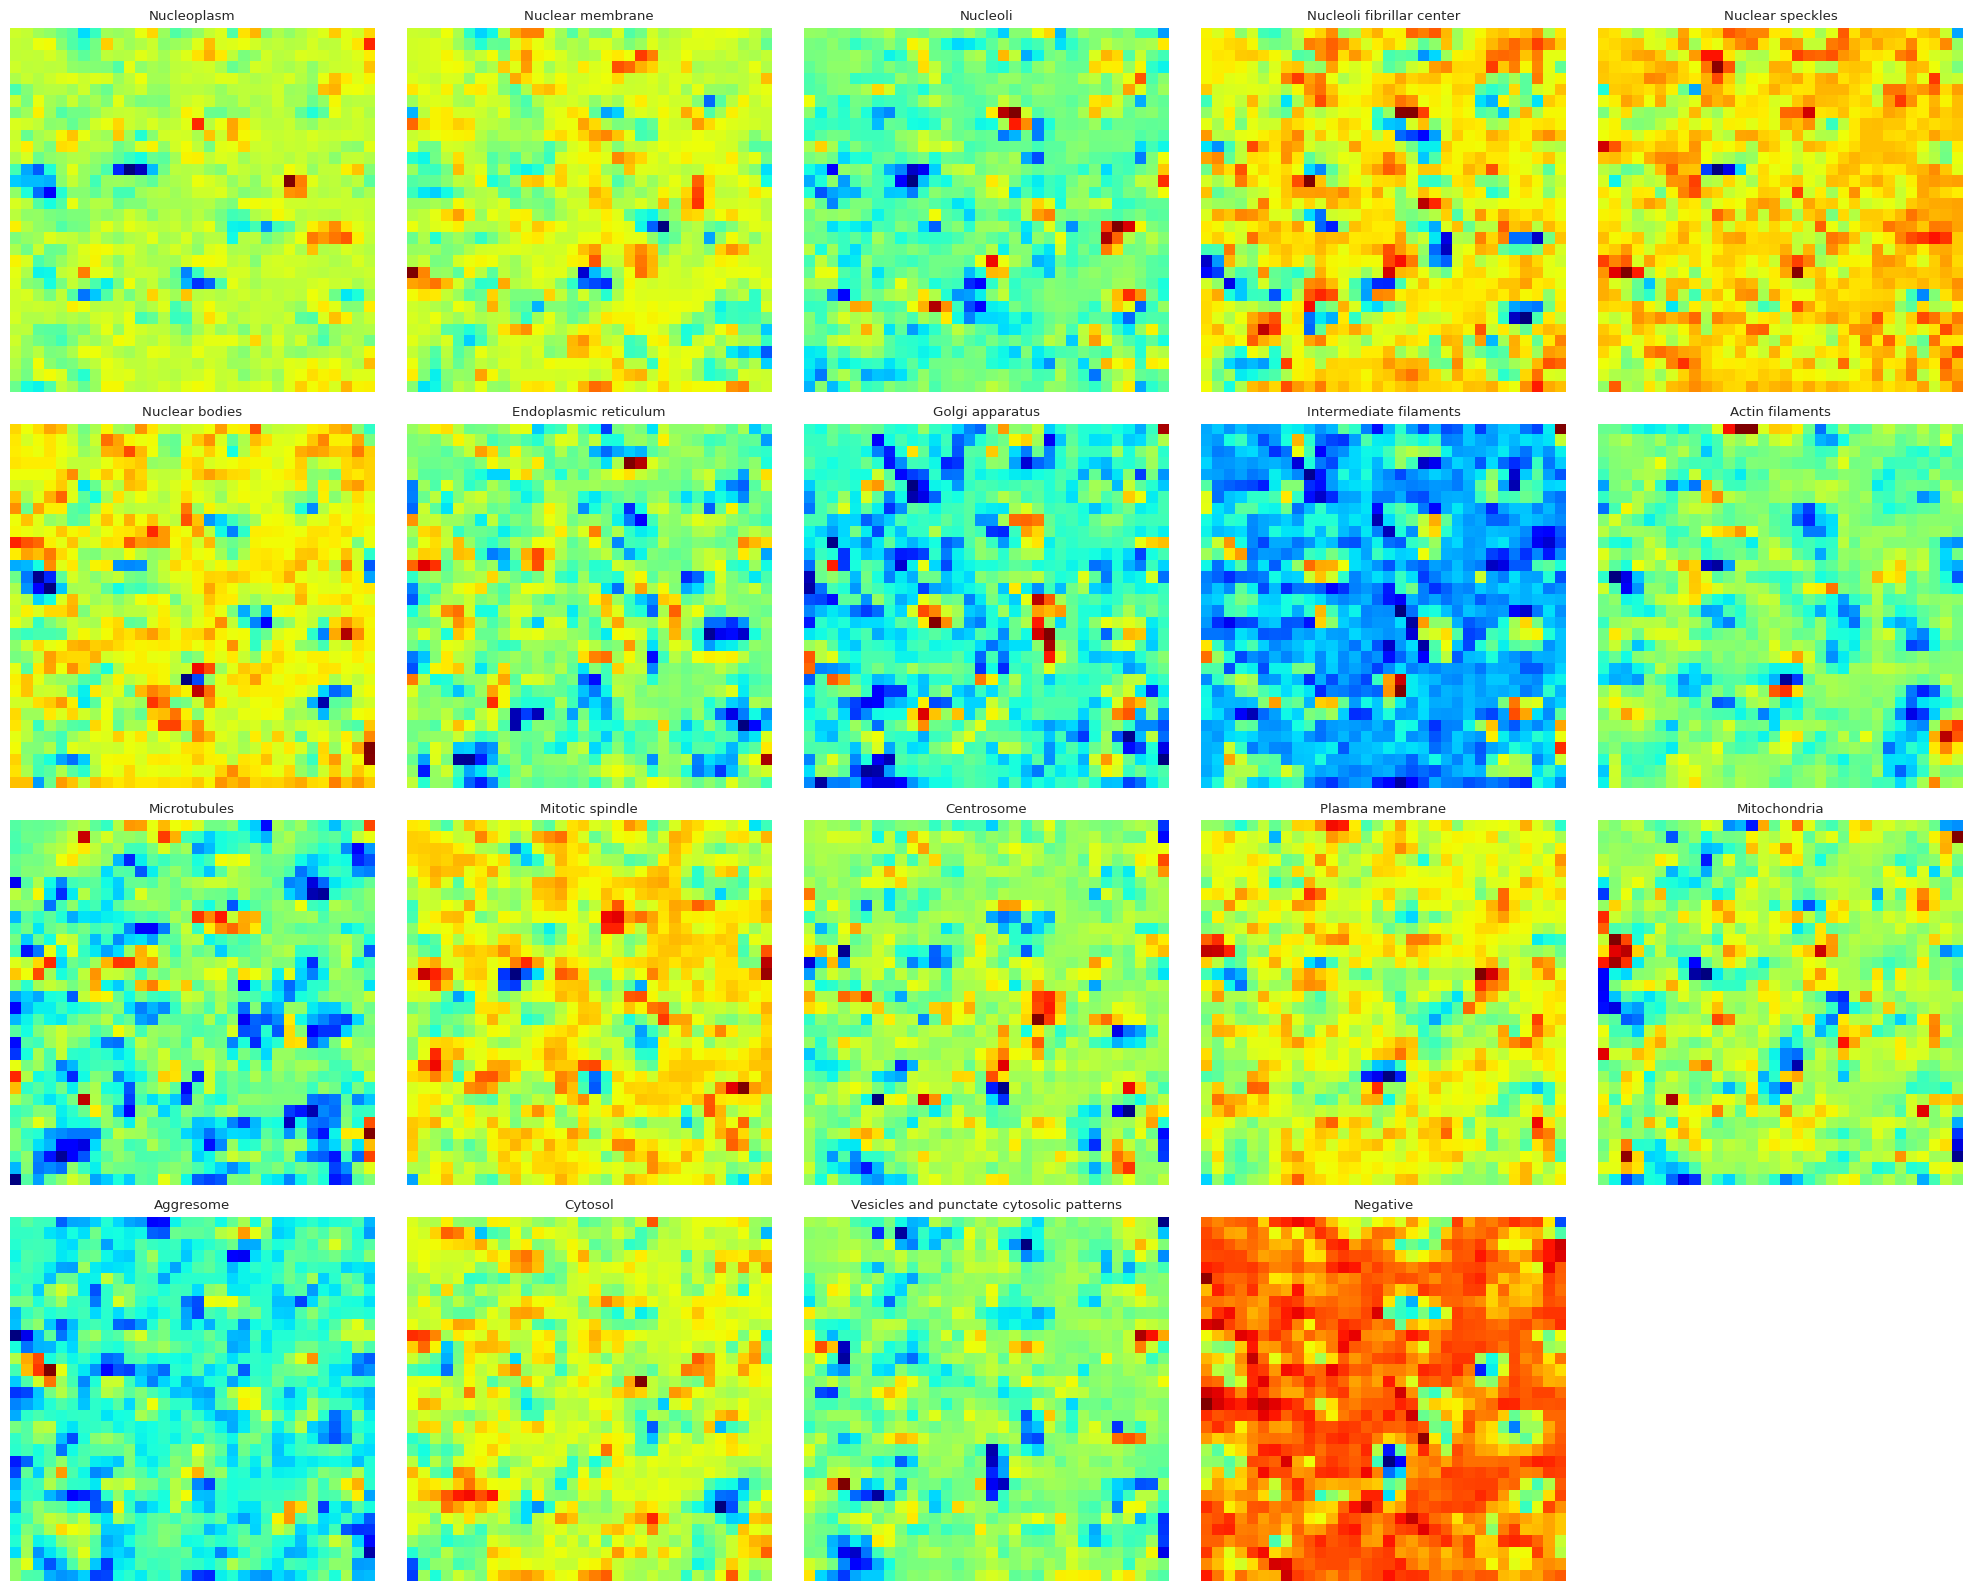

In [23]:
cams_for_image = output[0]  # Extrai os CAMs para a primeira imagem do batch (shape: [num_classes, H, W])

# Visualiza os mapas de ativação
visualize_cams(cams_for_image, class_names=list(classes_map.values()))